# Mixed Linear Model 

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

import statsmodels.api as sm
import scipy.stats as stats

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_new.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) if '/' in c else c for c in dta.columns]

In [5]:
dta.ccg.unique().shape

(74,)

## Add random feature

In [6]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [7]:
dta.shape

(1618, 14)

## Train test split 

In [8]:
train, test = train_test_split(dta,random_state=29)

In [9]:
y_train = train['ae_attendances_attendances'].values
X_train = train.drop(['ae_attendances_attendances','ccg','month'], axis=1)

y_test = test['ae_attendances_attendances'].values
X_test = test.drop(['ae_attendances_attendances','ccg','month'], axis=1)

## Model 

### Cross-validate 

In [10]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test = [],[]

y = dta['ae_attendances_attendances']
X = dta.drop(['ae_attendances_attendances','month', 'year'], axis=1)
    
for train_index, test_index in cv.split(X, y):
    
    model = MixedLM(endog=y.iloc[train_index].values, 
                    exog = X.iloc[train_index].drop(['ccg'],axis=1).values,
                    groups=X.iloc[train_index].ccg.values)

    ml_fit = model.fit()
    
    y_pred_test = model.predict(ml_fit.fe_params, 
                                 exog=X.iloc[test_index].drop(['ccg'],axis=1).values)
    y_pred_train = model.predict(ml_fit.fe_params, 
                                  exog=X.iloc[train_index].drop(['ccg'],axis=1).values)
    
    scores_test.append(r2_score(y.iloc[test_index],y_pred_test))
    scores_train.append(r2_score(y.iloc[train_index],y_pred_train))

In [11]:
res=pd.DataFrame()
res['test_score'] = scores_test
res['train_score'] = scores_train

res.describe()

,test_score,train_score
count,25.000000,25.000000
mean,0.092296,0.096086
std,0.052074,0.057714
min,-0.060924,-0.071581
25%,0.071561,0.082681
50%,0.099458,0.108742
75%,0.119344,0.126630
max,0.160848,0.188843


### Coefficients 

In [12]:
model = MixedLM(endog=y, exog = X.drop(['ccg'],axis=1).values, 
                groups=X.ccg.values)


ml_fit = model.fit()

In [13]:
ml_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:            MixedLM Dependent Variable: ae_attendances_attendances
No. Observations: 1618    Method:             REML                      
No. Groups:       74      Scale:              2285.2604                 
Min. group size:  12      Log-Likelihood:     -8795.4714                
Max. group size:  24      Converged:          Yes                       
Mean group size:  21.9                                                  
---------------------------------------------------------------------------
                 Coef.      Std.Err.      z       P>|z|    [0.025    0.975]
---------------------------------------------------------------------------
x1                 0.348       0.069     5.059    0.000     0.213     0.483
x2                -0.324       0.077    -4.190    0.000    -0.476    -0.172
x3                -0.062       0.074    -0.838    0.402    -0.206     0.083
x4                 0.086       0.100     0.863    0.388    -0.110     0.283
x5                 0.014       0.002     5.805    0.000     0.009     0.019
x6                -1.392       0.641    -2.170    0.030    -2.649    -0.135
x7                -5.477       1.295    -4.231    0.000    -8.014    -2.940
x8                 4.230       2.723     1.554    0.120    -1.107     9.566
x9                 5.912       2.998     1.972    0.049     0.037    11.787
x10                6.558       4.167     1.574    0.116    -1.609    14.724
Group Var      67340.324     262.242                                       
========================================================================

"""

### Residuals 

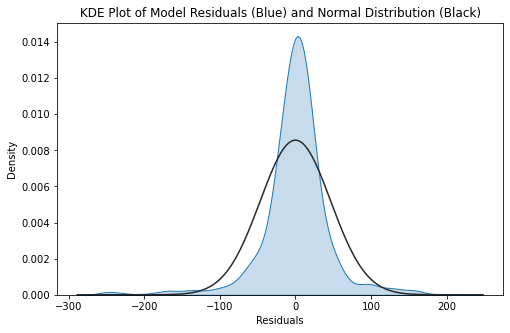

In [14]:
fig = plt.figure(figsize = (8, 5))


ax = sns.distplot(ml_fit.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")
plt.show()

### Q-Q Plot 

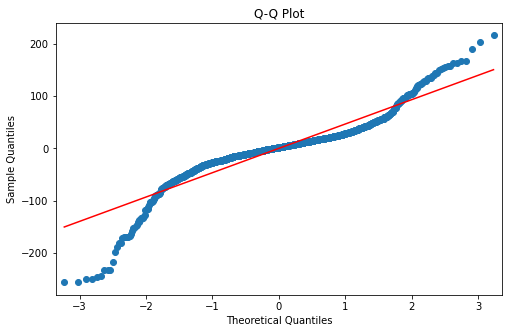

In [15]:
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111)

sm.qqplot(ml_fit.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

plt.show()

### Residuals by CCG 

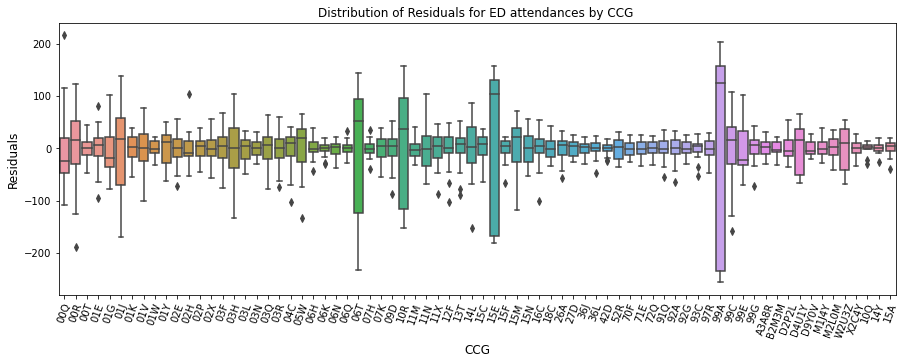

In [16]:
fig = plt.figure(figsize = (15, 5))

ax = sns.boxplot(x = ml_fit.model.groups, y = ml_fit.resid)

ax.set_title("Distribution of Residuals for ED attendances by CCG ")
ax.set_ylabel("Residuals", fontsize=12)
ax.set_xlabel("CCG", fontsize=12)
plt.xticks(rotation=70)
plt.show()